In [1]:
%pylab inline
import glob, os, sys, fnmatch
from astropy.io import fits
import astropy.table
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate 

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,'/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/python/')
import run_model

In [604]:
cont_files = glob.glob('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitSpectra/split_files/*_split_flux.fits')

In [4]:
hdulist = fits.open(cont_files[0])
ObsMeta = astropy.table.Table(hdulist[1].data)

In [4]:
Mhdu = fits.open('/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/good_meta_rich.fits')
MetaData = astropy.table.Table(Mhdu[1].data)
def get_specnos(meta):
    plate = meta['PLATE']
    image = meta['IMG']
    this_meta = MetaData[(MetaData['PLATE'] == plate) & (MetaData['IMG'] == image) & ((MetaData['CAMERAS'] == 'b1')|(MetaData['CAMERAS'] == 'b2'))]
    specnos = this_meta['SPECNO']
    return np.array(specnos)

In [5]:
wave = np.linspace(360,630,(630-360)*10)
def make_mean_cont(hdulist, specnos, wave):
    spectra = []
    for specno in specnos:
        try:
            data = hdulist[str(specno)].data
            cont = interpolate.interp1d(data['WAVE'], data['CONT'], bounds_error=False, fill_value=0)
            spectra.append(cont(wave))
        except:
            pass
    return np.mean(spectra, axis = 0)

In [6]:
def plot_mean_observations(hdu_list):
    ObsMeta = astropy.table.Table(hdu_list[1].data)
    color=iter(cm.rainbow(np.linspace(0,1,7)))
    plt.figure()
    for observation in ObsMeta:
        Model = run_model.RunSkyModel(observation)
        specnos = get_specnos(observation)
        mean_cont = make_mean_cont(hdu_list, specnos)
        c=next(color)
        plt.plot(wave, mean_cont, '-', color = c, label = observation['IMG'])
        plt.plot(Model.wave_range, Model.total_flux, '--', color = c)
        plt.title("Plate: %d" % observation['PLATE'])
    plt.legend()
    plt.xlim(360,630)

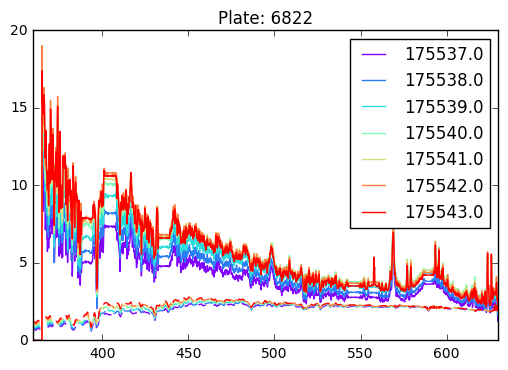

In [8]:
for filen in cont_files[0:1]:
    hdulist = fits.open(filen)
    plot_mean_observations(hdulist)

## Fit the spectra

In [96]:
from lmfit import models, Parameters, Parameter, Model
from lmfit.models import LinearModel, ConstantModel

In [110]:
import get_zodi_spectra as zodi
import get_scatt_moon as moon
import get_isl_spectra as isl

In [1032]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
wave = np.linspace(360,630,(630-360)*10)

## 1) Fit full spectra

In [236]:
filen = np.random.choice(cont_files,1)[0]
hdulist = fits.open(filen)
ObsMeta = astropy.table.Table(hdulist[1].data)
observation = ObsMeta[0]

Z = zodi.ZodiSpectrum(observation)
Z.get_spectrum()
M = moon.MoonSpectrum(observation) 
M.get_spectrum()
I = isl.ISLSpectrum(observation)
I.get_spectrum()

specnos = get_specnos(observation)
mean_cont = make_mean_cont(hdulist, specnos, Z.wave_range)

def my_model(x, A, B, C, D, E, F, G):
    trans = Z.ext_curve**(Z.f_ext*D)
    zodi = A*Z.flux
    moon = B*M.flux
    isl = C*I.flux
    
    return F+moon+zodi+isl

In [953]:
Z.f_ext

-0.07494504579439365

In [237]:
mod = Model(my_model)
    
params = mod.make_params()

params.add('A', value = 10)
params.add('B', value = 10)
params.add('C', value = 10)
params.add('D', value = 100, min = 0.0001)
params.add('F', value = 0, min = 0)
#params.add('G', value = 1, min = 0.0001)
params.add('E', value = 10, min = 0.0001)
result = mod.fit(mean_cont, params, x = Z.wave_range)

In [238]:
result.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
A    -20.59     -inf      inf        0     True     None     None
B     12.02     -inf      inf        0     True     None     None
C     24.28     -inf      inf        0     True     None     None
D       100   0.0001      inf        0     True     None     None
E        10   0.0001      inf        0     True     None     None
F         0        0      inf        0     True     None     None
G      -inf     -inf      inf        0     True     None     None


(360, 630)

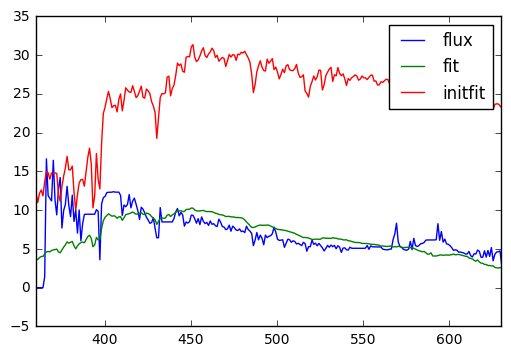

In [239]:
plt.plot(Z.wave_range, mean_cont, label = 'flux')
plt.plot(Z.wave_range, result.best_fit, label = 'fit')
plt.plot(Z.wave_range, result.init_fit, label = 'initfit')
plt.legend()
plt.xlim(360,630)

## 2) By wavelength

In [818]:
from sky_model import SkyModel

In [835]:
spectra

{'ISL': [], 'Moon': [], 'Zodi': []}

In [850]:
Sky = SkyModel()
Sky.run_model()

spectra = {}
for name in Sky.Model.keys():
    if (name == 'wave_range') | (name == 'total'):
        pass
    else:
        spectra[name] = []
        
Cont_spectra = []
for filen in cont_files:
    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = ObsMeta[0]

    ThisObs = SkyModel(observation)
    ThisObs.run_model()
            
    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, ThisObs.Model['wave_range'])
    Cont_spectra.append(mc[:-1])
    
    for name in spectra.keys():
        spectra[name].append(ThisObs.Model[name][:-1])

In [824]:
names = ['ISL', 'Moon', 'Zodi']

In [851]:
C = np.array(Cont_spectra)

In [825]:
import statsmodels.api as sm

In [877]:
Results = []
for i, y in enumerate(np.array(C).T):
    X = []
    for name in names:
        X.append(np.array(spectra[name]).T[i])
    X = np.vstack(X).T
    x = sm.add_constant(X)

    model = sm.OLS(y,x)
    results = model.fit()
    p = results.params
    Results.append(p)

In [878]:
Results = np.vstack(Results)

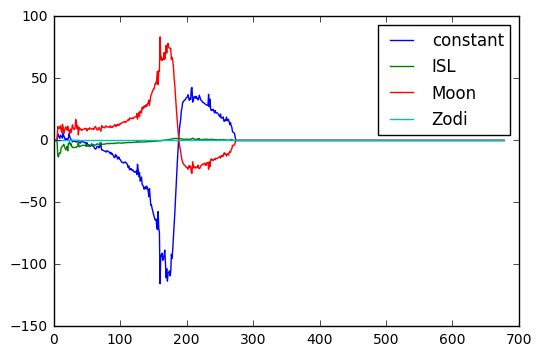

In [879]:
plt.plot(Results[:,0], label = 'constant')
plt.plot(Results[:,1], label = 'ISL')
plt.plot(Results[:,2], label = 'Moon')
plt.plot(Results[:,3], label = 'Zodi')
plt.legend()

In [282]:
from scipy.linalg import lstsq

In [880]:
def test_model(filen):
    Spectra = []

    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = ObsMeta[0]

    ThisObs = SkyModel(observation)
    ThisObs.run_model()
            
    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, ThisObs.Model['wave_range'])
    
    for name in names:
        Spectra.append(ThisObs.Model[name][:-1])
        
    X = sm.add_constant(np.array(Spectra).T)
    res = np.dot(Results,X.T)
    mod = res.diagonal()
    
    return mc[:-1], mod

In [881]:
def plot_results(results):
    plt.figure()
    plt.plot(Sky.Model['wave_range'][:-1], results[0], 'k-', label = 'data')
    plt.plot(Sky.Model['wave_range'][:-1], results[1], label = 'fit')
    plt.legend()
    plt.xlim(360,630)

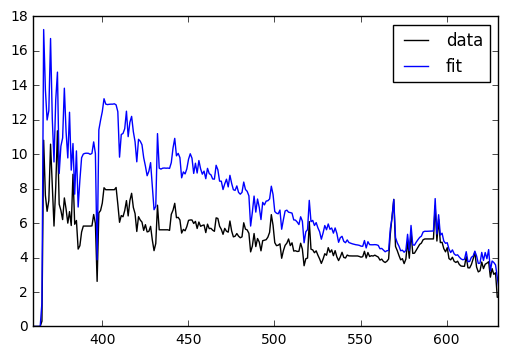

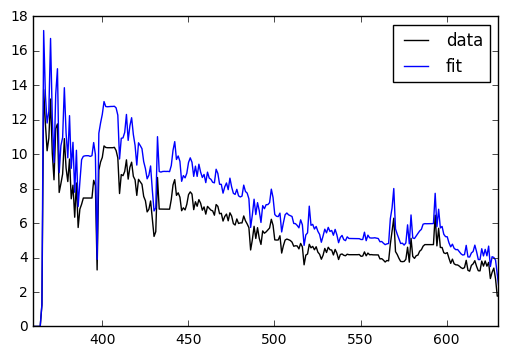

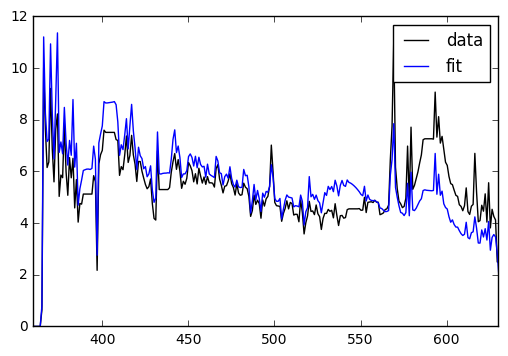

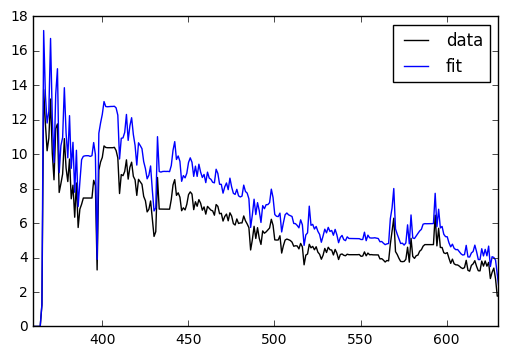

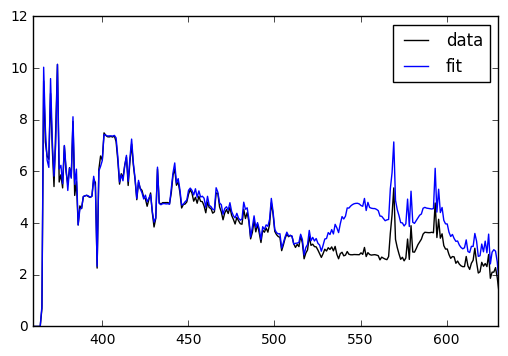

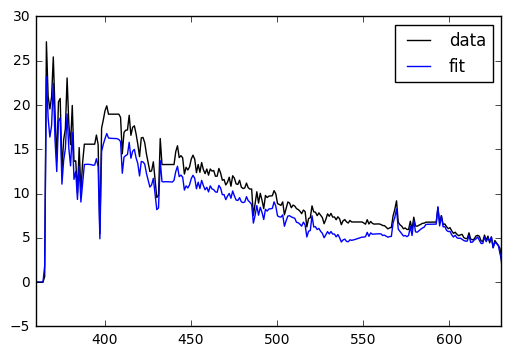

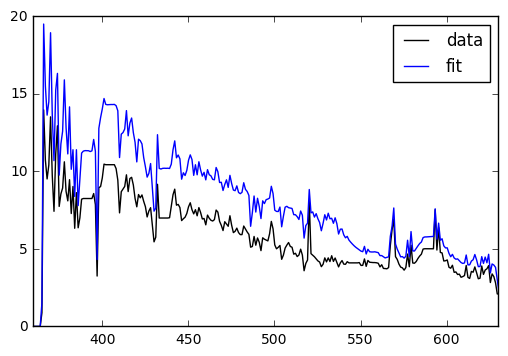

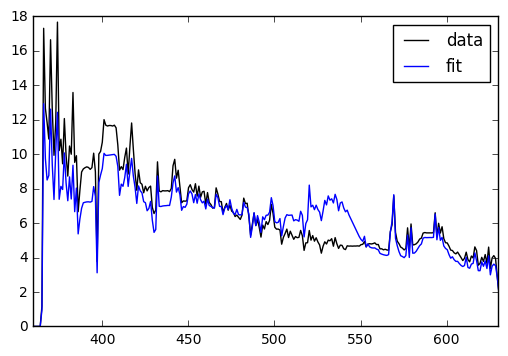

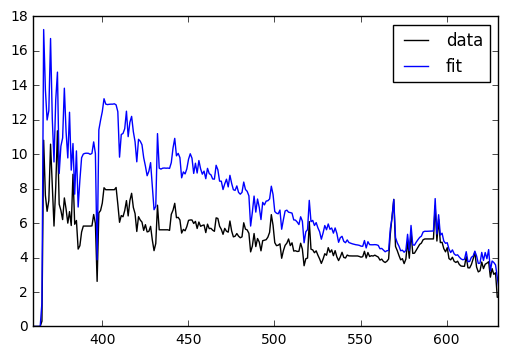

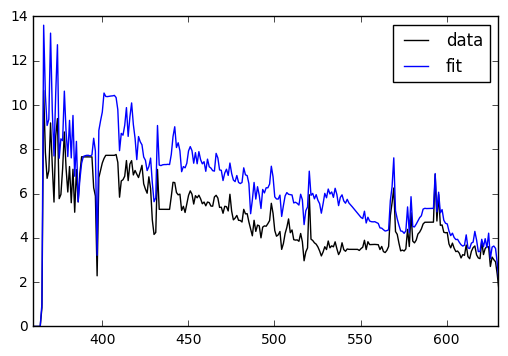

In [882]:
for filen in np.random.choice(cont_files,10):
    results = test_model(filen)
    plot_results(results)

## Fully linear model

In [740]:
XX = []
YY = []
for filen in cont_files:
    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = np.array(ObsMeta[0])

    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, Z.wave_range)
    
    #meta = observation[['MOON_ILL','AIRMASS' ,'AZ','AIRTEMP', 'DEWPOINT', 'DUSTA', 
    #                    'DUSTB', 'WINDD25M', 'WINDS25M', 'GUSTD', 'GUSTS', 'HUMIDITY', 
    #                    'PRESSURE', 'WINDD', 'WINDS','MOON_ALT', 'MOON_AZ', 'SUN_ALT', 
    #                    'SUN_AZ', 'MOON_D', 'MOON_SEP', 'SUN_MOON_SEP','ECL_LAT', 
    #                    'ECL_LON', 'GAL_LAT', 'GAL_LON','SEASON', 'HOUR', 'SOLARFLUX']]
    meta = observation[['MOON_ILL','AIRMASS' ,'MOON_ALT']]

    XX.append(meta.tolist())
    YY.append(mc)

In [640]:
np.vstack(XX).shape

(70, 29)

In [741]:
Results = []
for i, y in enumerate(np.vstack(YY).T):

    x = sm.add_constant(XX)
    model = sm.OLS(y, x)
    results = model.fit()
    p = results.params
    Results.append(p)

In [742]:
Results = np.vstack(Results)

In [743]:
names = ['MOON_ILL','AIRMASS' ,'MOON_ALT','CONSTANT']

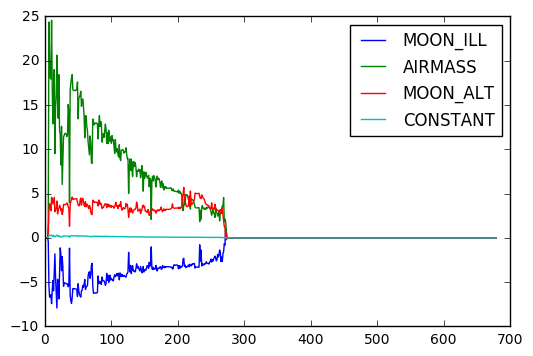

In [744]:
for i, r in enumerate(Results.T):
    plt.plot(r, label = names[i])
plt.legend()

In [756]:
def test_model(filen):
    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = np.array(ObsMeta[0])

    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, Z.wave_range)

    meta = observation[['MOON_ILL','AIRMASS' ,'MOON_ALT']]

    XX = np.hstack([meta.tolist(), 1])
    
    XXX = np.tile(np.array(XX), (Results.shape[0],1))

    res = np.dot(Results, XXX.T)
    mod = res.diagonal()
    plt.figure()
    plt.plot(Z.wave_range,mc, label = 'flux')
    plt.plot(Z.wave_range, mod, label = 'mod')
    plt.legend()
    
    return mc, mod


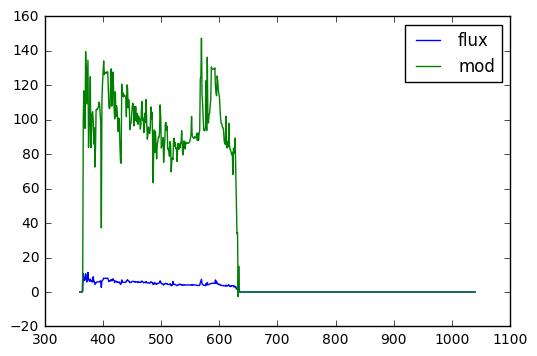

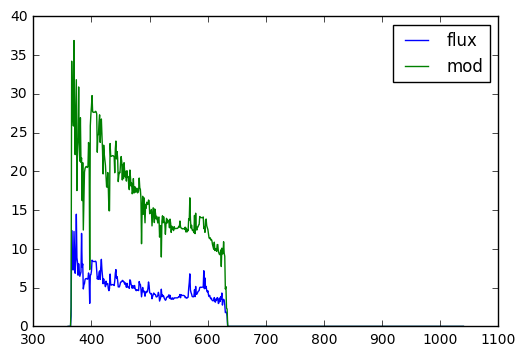

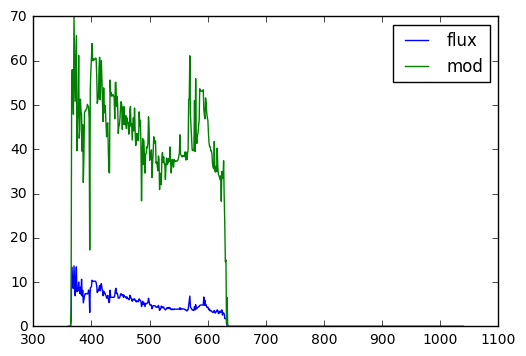

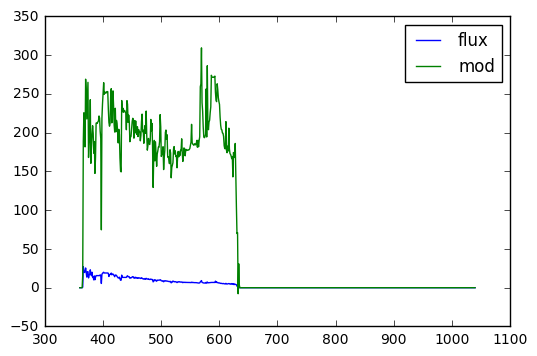

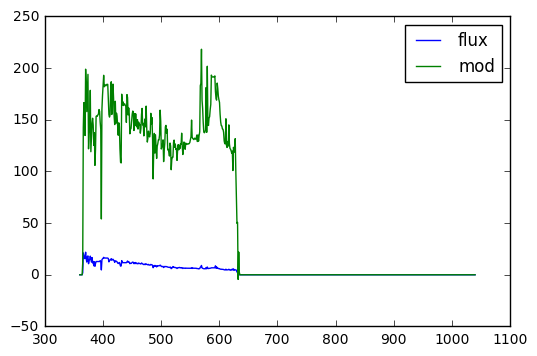

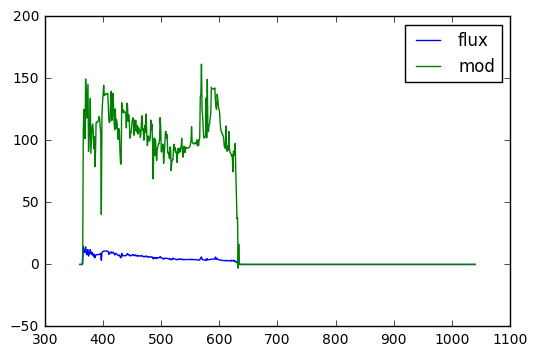

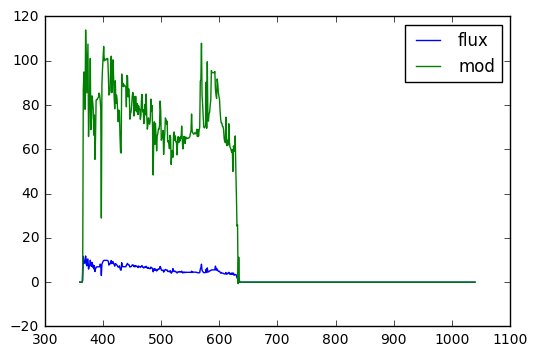

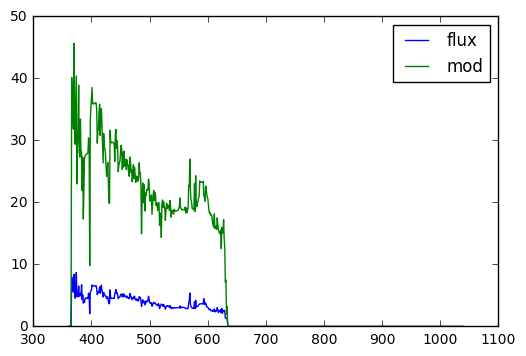

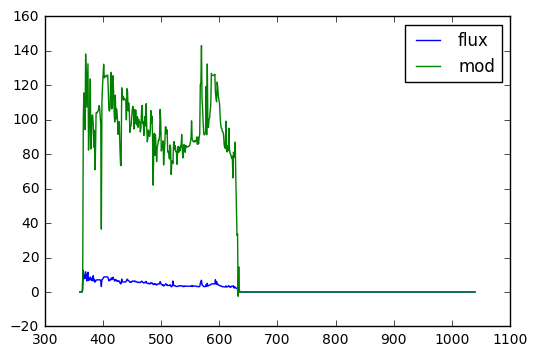

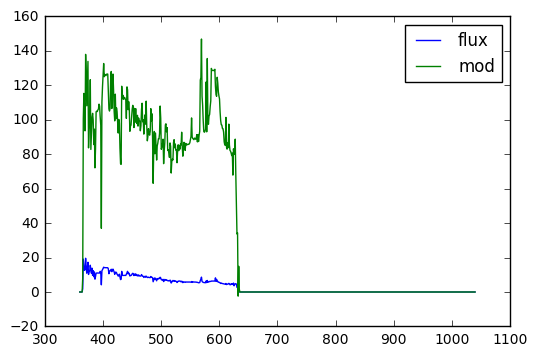

In [757]:
for filen in np.random.choice(cont_files,10):
    results = test_model(filen)

## 4) More complex nonlinear model

In [889]:
def BrightModel(Cont, Data):        
    def bright_sky_model(x, A, B, C, a1, a2, a3, a4, a5, a6, a7, a8):
        MoonPhase, k_V, MoonX, ObsX, MoonSep, I, V, zodi, isl = x

        m = -a1+a2*np.abs(MoonPhase)+a3*10**(-9)*MoonPhase**(4)
        I_V = 10**(-0.4*(m+a4))

        moon_ext = 10**(-0.4*k_V*MoonX)*(1-10**(-0.4*k_V*ObsX))

        fR = 10**(a5)*(a6+(np.cos(np.deg2rad(MoonSep)))**(2))
        fM = 10**(a7 - (MoonSep/a8))
        
        B = (fR+fM)*I_V*moon_ext
        V_scatt = (20.7233 - np.log(B)/34.08)/0.92104

        moon = I * 10 ** (-0.4*(V_scatt - V)) * np.pi*10**(17) 

        Zodi = A*zodi
        ISL = B*isl
        sky = moon + Zodi + ISL + C

        return sky
    
    mod = Model(bright_sky_model)
    params = mod.make_params()
    params.add('A', value = 1)
    params.add('B', value = 1)
    params.add('C', value = 0)
    
    params.add('a1', value = 12.73, min = 0, max = 20)
    params.add('a2', value = 0.025, min = .001, max = 1)
    params.add('a3', value = 4, min = 0) #4*10**(-9)
    params.add('a4', value = 16.57, min = 0, max = 20)
    params.add('a5', value = 5.36, min = 0, max = 10)
    params.add('a6', value = 1.06, min = 0, max = 5)
    params.add('a7', value = 6.15, min = 0, max = 10)
    params.add('a8', value = 40., min = 0, max = 100)
       
    #xx = np.array(Data)
    #print(mod.eval(params, x = xx))
    result = mod.fit(Cont, params, x = Data)
    #print(result.fit_report())
    return result

In [815]:
from sky_model import SkyModel

In [883]:
Data = []
Cont_spectra = []
for filen in cont_files:
    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = ObsMeta[0]
    ThisObs = SkyModel(observation)
    ThisObs.run_model()
    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, ThisObs.Model['wave_range'])
    Cont_spectra.append(mc)
    
    zodi = ThisObs.Model['Zodi']
    isl = ThisObs.Model['ISL']
    moonphase = np.ones(len(zodi))*ThisObs.ObsMeta['MOON_PHASE']
    moonx = np.ones(len(zodi))*ThisObs.M.ObsMeta['MOON_X']
    obsx = np.ones(len(zodi))*ThisObs.M.ObsMeta['OBS_X']
    moonsep = np.ones(len(zodi))*ThisObs.M.ObsMeta['MOON_SEP']
    k_V = np.ones(len(zodi))*ThisObs.M.k_V
    I = ThisObs.M.I
    V = np.ones(len(zodi))*ThisObs.M.V
    
    Data.append([moonphase, k_V, moonx, obsx, moonsep, I, V, zodi, isl])

In [884]:
Cont_spectra = np.array(Cont_spectra)

In [885]:
Cont_spectra.shape

(70, 680)

In [886]:
Data = np.array(Data)

In [896]:
np.where(np.isnan(Data))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [897]:
Cont_spectra = np.array(Cont_spectra)
Data = np.array(Data)
Results = []
for i, cont in enumerate(Cont_spectra.T):
    data = Data.T[i,:,:]
    try:
        results = BrightModel(cont, data)
        Results.append(results)
    except:
        print('didnt work: ',i)
    

didnt work:  679


In [898]:
Results = np.array(Results)

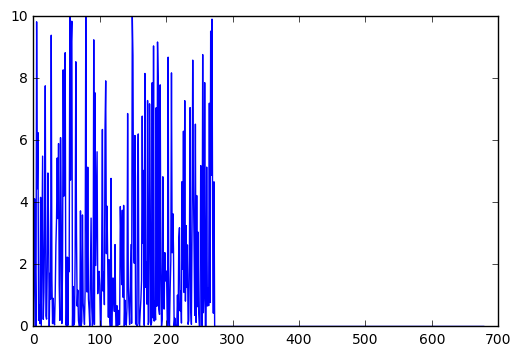

In [952]:
A = []
for i, result in enumerate(Results):
    A.append(result.params['a5'].value)
plt.plot(A)

In [921]:
def test_model(results,X):
    MoonPhase, k_V, MoonX, ObsX, MoonSep, I, V, zodi, isl = X
    a1 = results.params['a1'].value
    a2 = results.params['a2'].value
    a3 = results.params['a3'].value
    a4 = results.params['a4'].value
    a5 = results.params['a5'].value
    a6 = results.params['a6'].value
    a7 = results.params['a7'].value
    a8 = results.params['a8'].value
    
    A = results.params['A'].value
    B = results.params['B'].value
    C = results.params['C'].value
    
    m = -a1+a2*np.abs(MoonPhase)+a3*10**(-9)*MoonPhase**(4)
    I_V = 10**(-0.4*(m+a4))

    moon_ext = 10**(-0.4*k_V*MoonX)*(1-10**(-0.4*k_V*ObsX))

    fR = 10**(a5)*(a6+(np.cos(np.deg2rad(MoonSep)))**(2))
    fM = 10**(a7 - (MoonSep/a8))

    B = (fR+fM)*I_V*moon_ext
    V_scatt = (20.7233 - np.log(B)/34.08)/0.92104

    moon = I * 10 ** (-0.4*(V_scatt - V)) * np.pi*10**(17) 

    Zodi = A*zodi
    ISL = B*isl
    sky = moon + Zodi + ISL + C
    
    return sky

In [926]:
# create new spectrum
Sky = SkyModel()
Sky.run_model()


/Users/parkerf/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


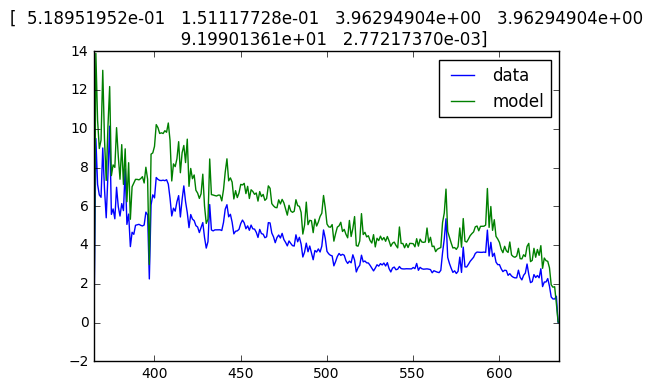

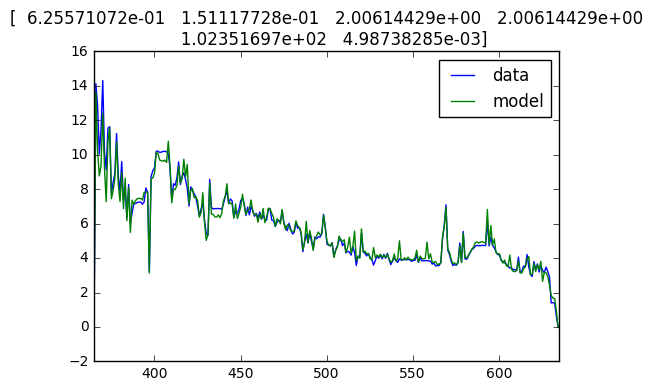

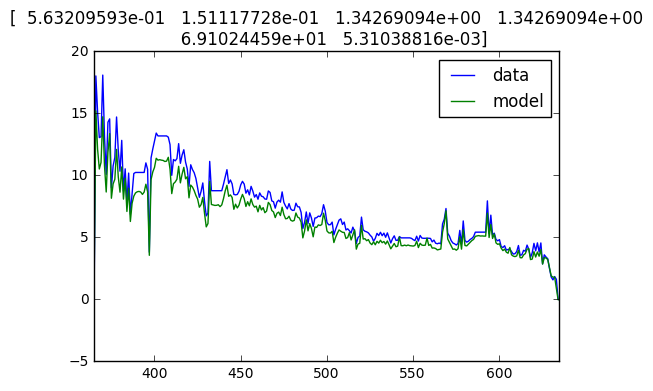

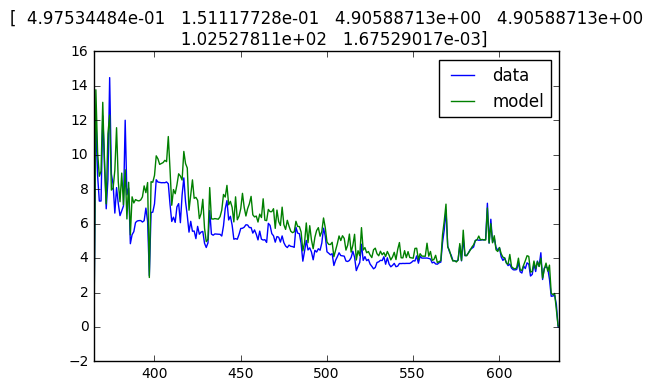

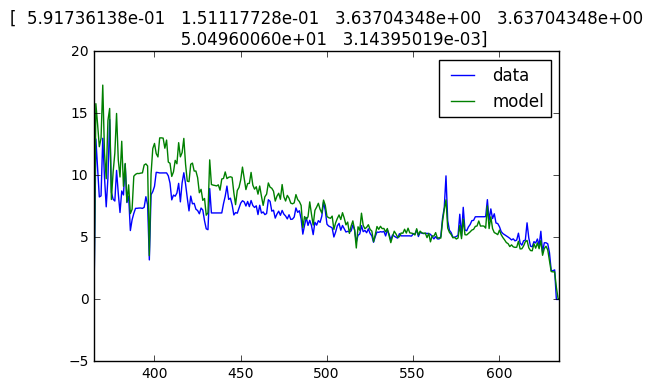

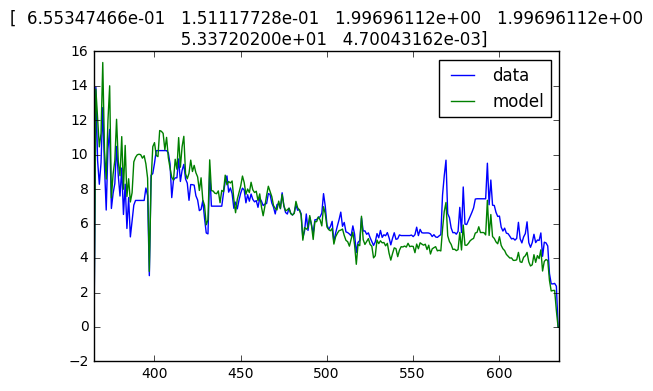

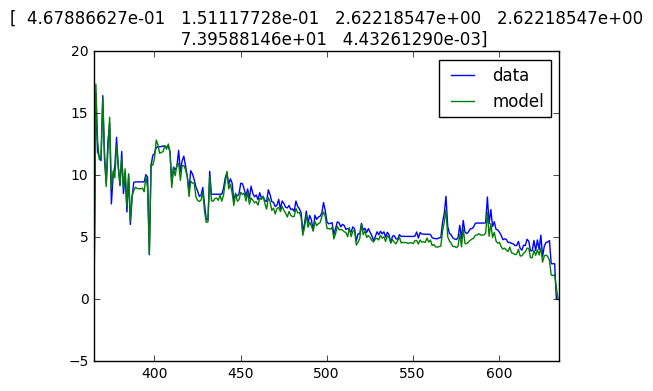

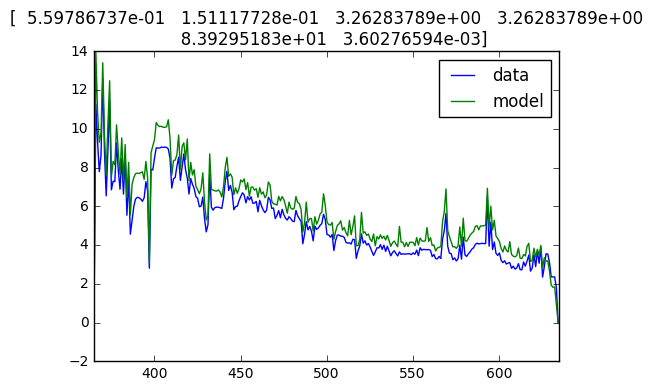

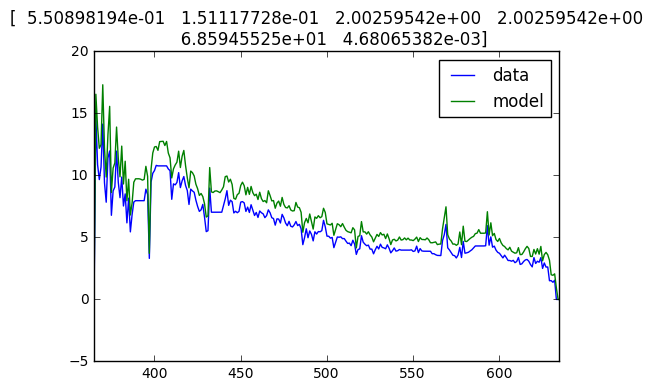

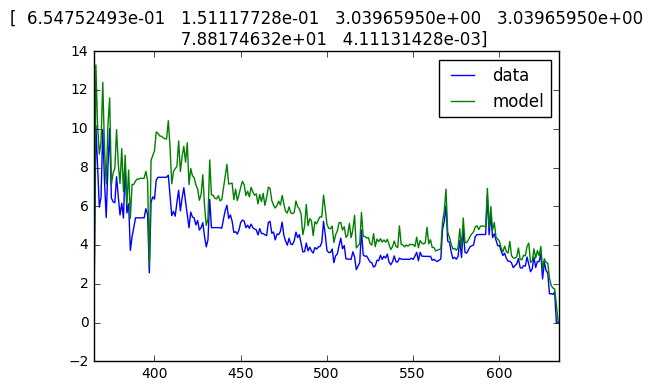

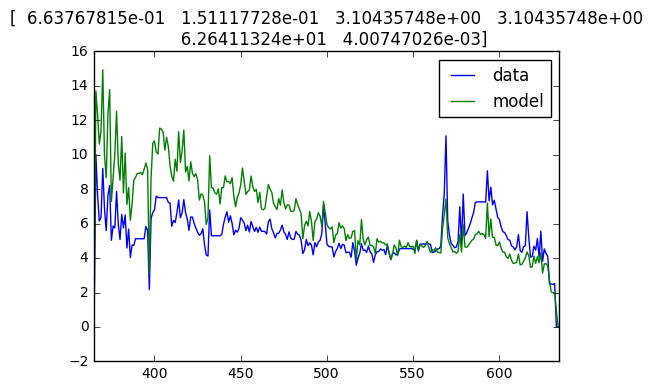

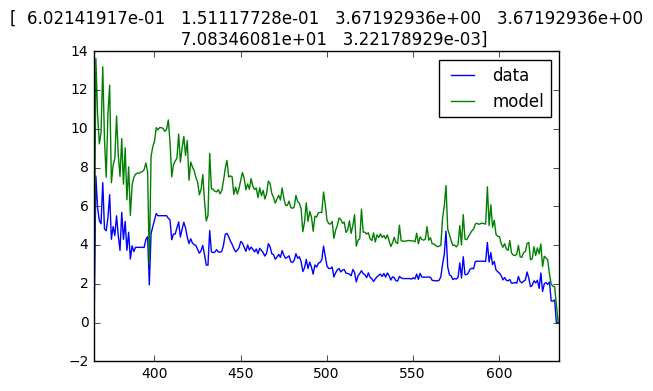

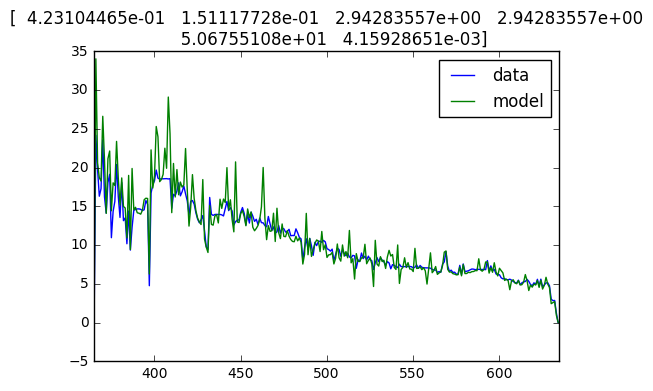

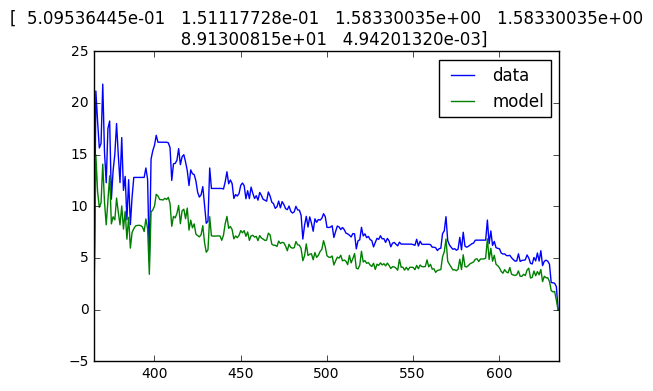

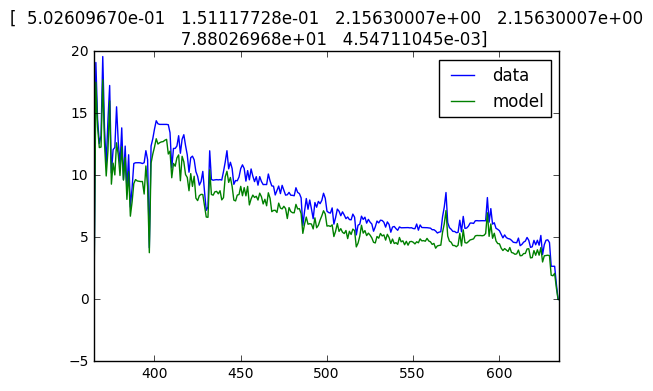

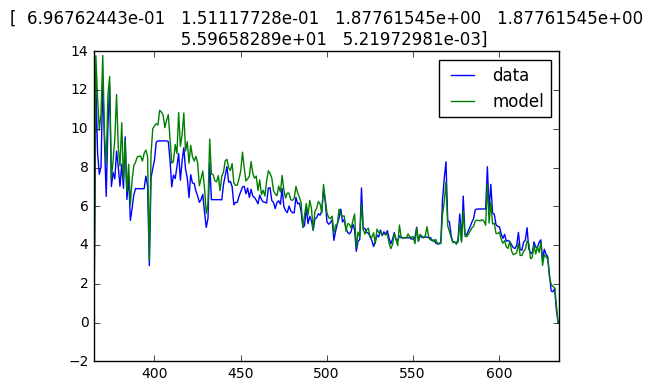

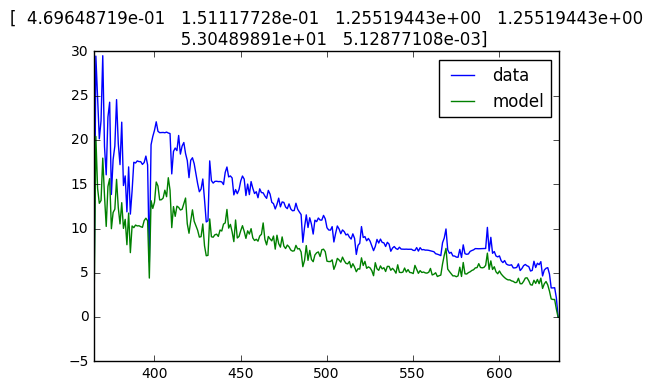

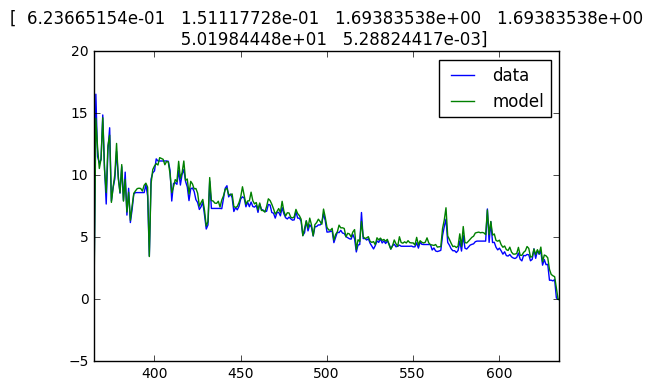

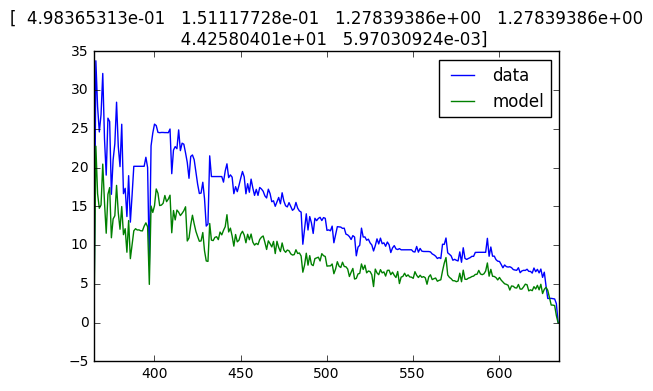

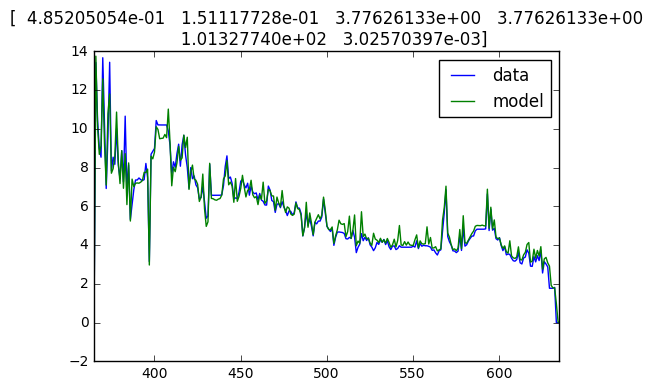

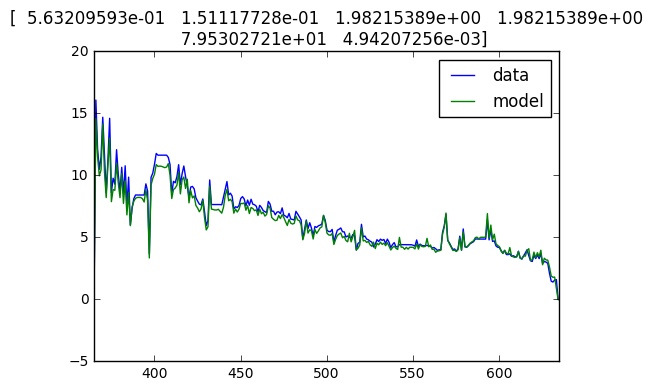

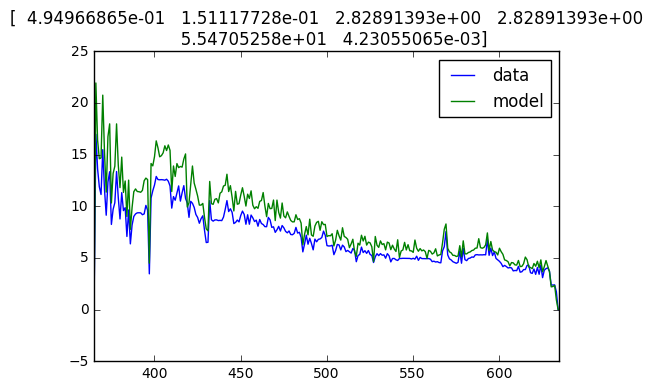

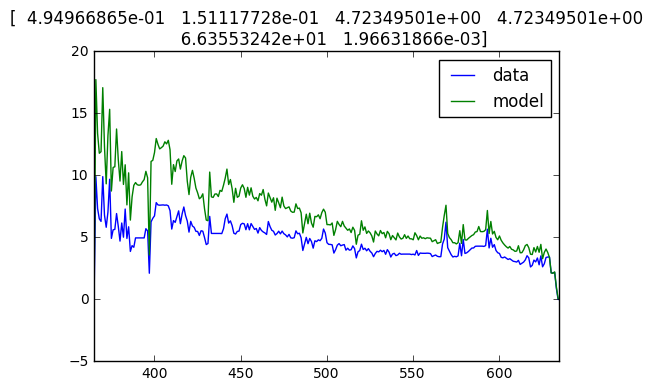

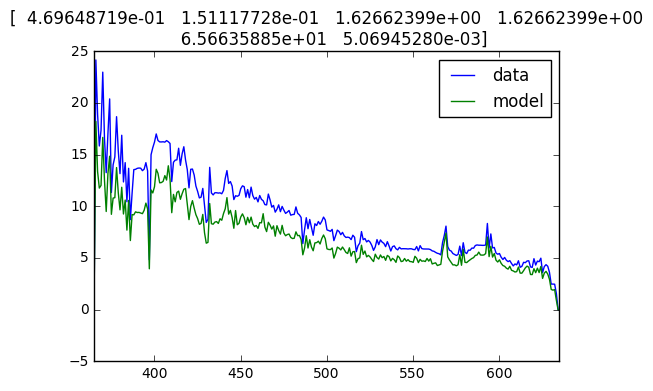

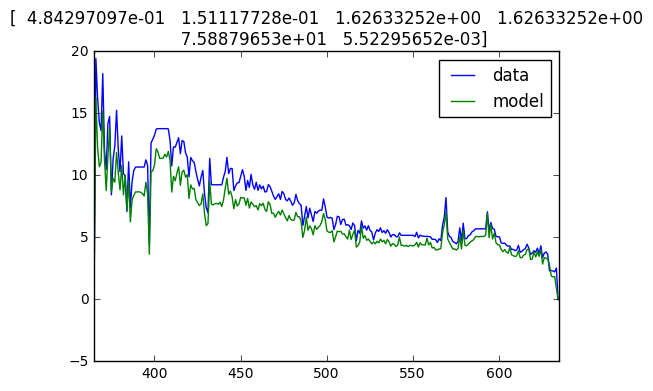

In [946]:
for i, This_Data in enumerate(Data[0:25]):
    This_spectrum = Cont_spectra[i]
    Model_Spectrum = []
    for ii, result in enumerate(Results):
        Model_Spectrum.append(test_model(result, This_Data[:,ii]))
    
    plt.figure()
    plt.plot(Sky.Model['wave_range'], This_spectrum, label = 'data')
    plt.plot(Sky.Model['wave_range'][:-1], Model_Spectrum, label = 'model')
    plt.legend()
    plt.xlim(365,635)
    plt.title(This_Data[:,0][0:6])

## New Model

In [989]:
def NewModelSpectrum(filen):

    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = ObsMeta[0]
    ThisObs = SkyModel(observation)
    ThisObs.run_model()
    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, ThisObs.Model['wave_range'])

    ext_curve = ThisObs.S.extinction_curve(ThisObs.ObsMeta['AIRMASS'])
    zodi = ThisObs.Z.zodi_flux
    isl = ThisObs.I.isl_spectrum
    moon = ThisObs.M.moon_spectrum
    moon_sep = ThisObs.ObsMeta['MOON_SEP']
    solar_flux = ThisObs.ObsMeta['SOLARFLUX']


    def bright_sky_model(x, A, B, C, fscatt_z, fscatt_i, fscatt_m):

        Zodi = zodi*(ext_curve**(fscatt_z))
        ISL = isl*(ext_curve**(fscatt_i))
        Moon = moon*(ext_curve**fscatt_m)*(A*np.cos(np.deg2rad(moon_sep)))
        solar = B*solar_flux
        sky = Moon + Zodi + ISL + solar + C

        return sky

    mod = Model(bright_sky_model)
    params = mod.make_params()
    params.add('A', value = 1)
    params.add('B', value = .01)
    params.add('C', value = 0)
    params.add('fscatt_z', value = .001, min = .001)
    params.add('fscatt_i', value = .005, min = .001)
    params.add('fscatt_m', value = 10, min = 0.001)

    result = mod.fit(mc, params, x = ThisObs.Model['wave_range'])
    print(result.fit_report())
    plt.figure()
    plt.plot(ThisObs.Model['wave_range'], mc, label = 'data')
    plt.plot(ThisObs.Model['wave_range'], result.best_fit, label = 'fit')
    plt.legend()
    plt.xlim(365,635)
    plt.show()

[[Model]]
    Model(bright_sky_model)
[[Fit Statistics]]
    # function evals   = 30
    # data points      = 680
    # variables        = 6
    chi-square         = 3192.003
    reduced chi-square = 4.736
    Akaike info crit   = 1063.492
    Bayesian info crit = 1090.624
[[Variables]]
    A:          3627.07258 +/- 0        (0.00%) (init= 1)
    B:          0.00790415 +/- 0        (0.00%) (init= 0.01)
    C:         -0.18903056 +/- 0        (0.00%) (init= 0)
    fscatt_z:   0.00100000 +/- 0        (0.00%) (init= 0.001)
    fscatt_i:   785.349264 +/- 0        (0.00%) (init= 0.005)
    fscatt_m:   7796.92191 +/- 0        (0.00%) (init= 10)



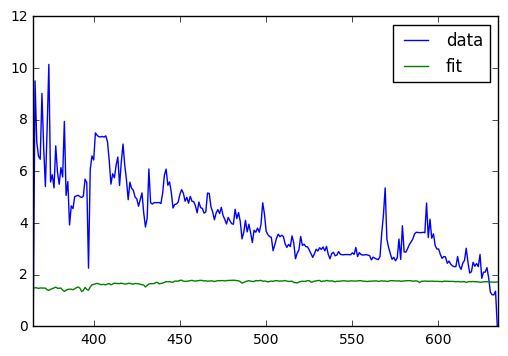

[[Model]]
    Model(bright_sky_model)
[[Fit Statistics]]
    # function evals   = 36
    # data points      = 680
    # variables        = 6
    chi-square         = 6312.411
    reduced chi-square = 9.366
    Akaike info crit   = 1527.163
    Bayesian info crit = 1554.295
[[Variables]]
    A:          617.426659 +/- 0        (0.00%) (init= 1)
    B:          0.00802817 +/- 0        (0.00%) (init= 0.01)
    C:          0.51118933 +/- 0        (0.00%) (init= 0)
    fscatt_z:   0.00100000 +/- 0        (0.00%) (init= 0.001)
    fscatt_i:   631.614677 +/- 0        (0.00%) (init= 0.005)
    fscatt_m:   2109.57933 +/- 0        (0.00%) (init= 10)



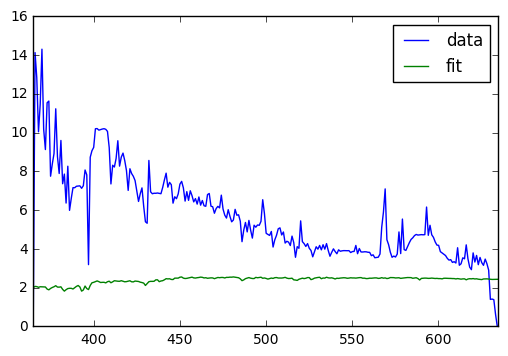

[[Model]]
    Model(bright_sky_model)
[[Fit Statistics]]
    # function evals   = 108
    # data points      = 680
    # variables        = 6
    chi-square         = 1936.542
    reduced chi-square = 2.873
    Akaike info crit   = 723.665
    Bayesian info crit = 750.798
[[Variables]]
    A:         -2488.72047 +/- 0        (0.00%) (init= 1)
    B:          0.16552601 +/- 0        (0.00%) (init= 0.01)
    C:         -10.8796030 +/- 0        (0.00%) (init= 0)
    fscatt_z:   0.00100000 +/- 0        (0.00%) (init= 0.001)
    fscatt_i:   4416.88573 +/- 0        (0.00%) (init= 0.005)
    fscatt_m:   11.8790997 +/- 0        (0.00%) (init= 10)



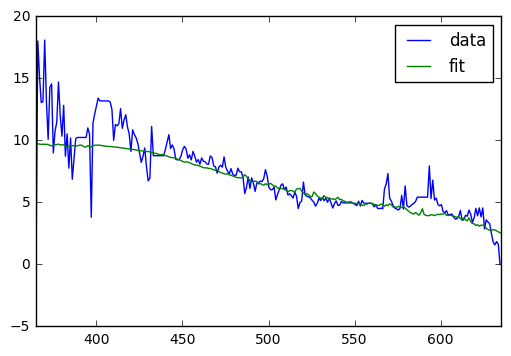

[[Model]]
    Model(bright_sky_model)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 680
    # variables        = 6
    chi-square         = 4119.064
    reduced chi-square = 6.111
    Akaike info crit   = 1236.876
    Bayesian info crit = 1264.009
[[Variables]]
    A:          1320.54942 +/- 0        (0.00%) (init= 1)
    B:         -0.71133458 +/- 0        (0.00%) (init= 0.01)
    C:          70.4643079 +/- 0        (0.00%) (init= 0)
    fscatt_z:   0.00100000 +/- 0        (0.00%) (init= 0.001)
    fscatt_i:   14711.3976 +/- 0        (0.00%) (init= 0.005)
    fscatt_m:   9266.36548 +/- 0        (0.00%) (init= 10)



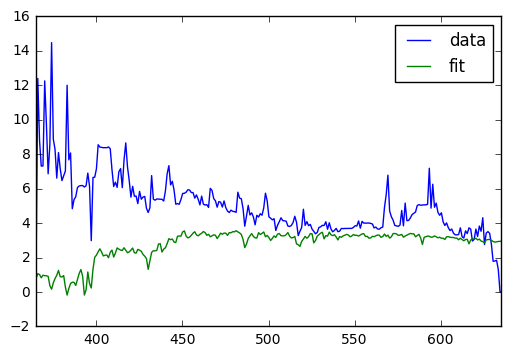

[[Model]]
    Model(bright_sky_model)
[[Fit Statistics]]
    # function evals   = 14002
    # data points      = 680
    # variables        = 6
    chi-square         = 6946.082
    reduced chi-square = 10.306
    Akaike info crit   = 1592.211
    Bayesian info crit = 1619.344
[[Variables]]
    A:          34.9618006 +/- 0        (0.00%) (init= 1)
    B:          0.00945224 +/- 0        (0.00%) (init= 0.01)
    C:         -0.05651440 +/- 0        (0.00%) (init= 0)
    fscatt_z:   0.00100000 +/- 0        (0.00%) (init= 0.001)
    fscatt_i:   0.00100000 +/- 0        (0.00%) (init= 0.005)
    fscatt_m:   0.00124559 +/- 0        (0.00%) (init= 10)



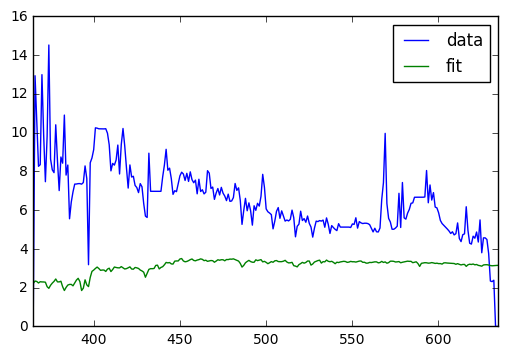

In [990]:
for filen in cont_files[0:5]:
    NewModelSpectrum(filen)

In [1033]:
Data = []
Cont_spectra = []
for filen in cont_files:
    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = ObsMeta[0]
    ThisObs = SkyModel(observation)
    ThisObs.run_model()
    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, ThisObs.Model['wave_range'])
    Cont_spectra.append(mc)
    
    ext_curve = ThisObs.S.extinction_curve(ThisObs.ObsMeta['AIRMASS'])
    zodi = ThisObs.Z.zodi_flux
    isl = ThisObs.I.isl_spectrum
    moon = ThisObs.M.moon_spectrum
    moon_sep = np.ones(len(zodi))*ThisObs.ObsMeta['MOON_SEP']
    solar_flux = np.ones(len(zodi))*ThisObs.ObsMeta['SOLARFLUX']

    Data.append([ext_curve, zodi, isl, moon, moon_sep, solar_flux])

In [1034]:
def NewModelWavelength(cont, data):

    def bright_sky_model(x, A, B, C, fscatt_z,fscatt_i):
        ext_curve, zodi, isl, moon, moon_sep, solar_flux = x

        Zodi = zodi*(ext_curve)**fscatt_z
        ISL = isl*(ext_curve)**fscatt_i
        Moon = moon*(ext_curve)*(A*np.cos(np.deg2rad(moon_sep)))
        solar = B*solar_flux
        sky = Moon + Zodi + ISL + solar + C

        return sky

    mod = Model(bright_sky_model)
    params = mod.make_params()
    params.add('A', value = 1)
    params.add('B', value = .01)
    params.add('C', value = 0)
    params.add('fscatt_z', value = .2, min = .001)
    params.add('fscatt_i', value = .1, min = .001)
    #params.add('fscatt_m', value = .2, min = 0.001)

    result = mod.fit(cont, params, x = data)
    return result

In [1035]:
Cont_spectra = np.array(Cont_spectra)
Data = np.array(Data)
Results = []
for i, cont in enumerate(Cont_spectra.T):
    data = Data.T[i,:,:]
    try:
        results = NewModelWavelength(cont, data)
        Results.append(results)
    except:
        print('didnt work: ',i)

[2.7224568838290136e-164, 3.9013931258952161e-169, 2.0930489536301395e-171, 5.0737721922106444e-166, 7.891020119300765e-160, -0.0038390939367096517, -0.031470487557950615, -0.033104845362303119, -0.033776335527204111, -0.039333647041736461, -0.034428144281878237, -0.02429669834469669, -0.02344189135999496, -0.035147961673123167, -0.014685210494333314, -0.0089542110204749413, -0.022978812293489064, -0.033940710507434808, -0.041207410867840688, -0.026852558465140043, -0.027952586380447553, -0.038485273383635075, -0.01577925282537922, 0.00020611214104090521, -0.0045417593313766824, -0.01975555126254477, -0.013649460198946479, -0.020328711083750565, -0.022042092343192321, -0.021640883824718266, -0.021902220620181458, -0.02179621982574197, -0.021971571276783938, -0.021750664684309806, -0.021804863822906573, -0.029092121880182051, -0.029313872725126526, -0.0059639541918259376, -0.034248798105489101, -0.036928672448120509, -0.039462741107909607, -0.034317645776982091, -0.032382217955143233, -

(-0.01, 0.02)

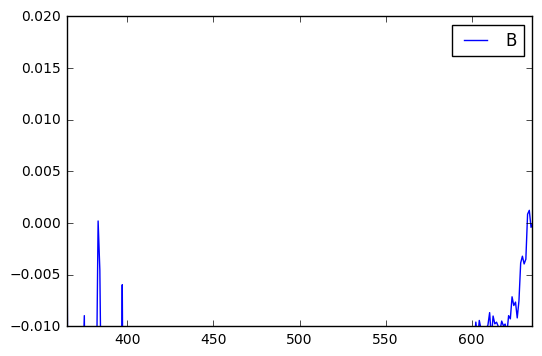

In [1056]:
for p in ['B']:
    l = []
    for i, result in enumerate(Results):
        l.append(result.params[p].value)
    print(l)
    plt.plot(Sky.Model['wave_range'],l, label = p)
plt.legend()
plt.xlim(365,635)
plt.ylim(-0.01,.02)

In [1037]:
def test_model(results,X):
    ext_curve, zodi, isl, moon, moon_sep, solar_flux = X
    fscatt_z = results.params['fscatt_z'].value
    fscatt_i = results.params['fscatt_i'].value
    #fscatt_m = results.params['fscatt_m'].value
    
    A = results.params['A'].value
    B = results.params['B'].value
    C = results.params['C'].value

    Zodi = zodi*(ext_curve**fscatt_z)
    ISL = isl*(ext_curve)**fscatt_i
    Moon = moon*(ext_curve)*(A*np.cos(np.deg2rad(moon_sep)))
    solar = B*solar_flux
    sky = Moon + Zodi + ISL + solar + C

    return sky

/Users/parkerf/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


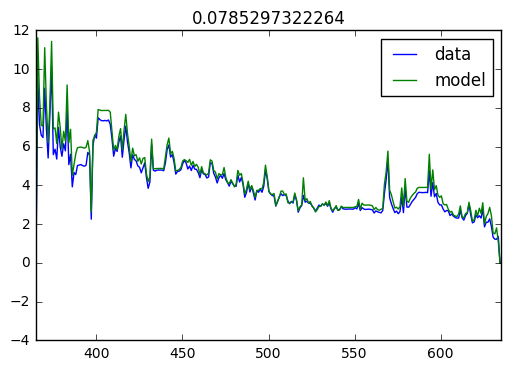

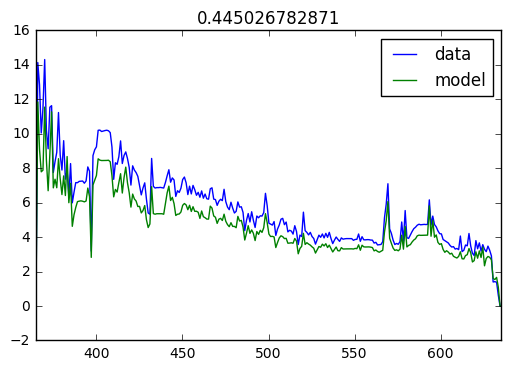

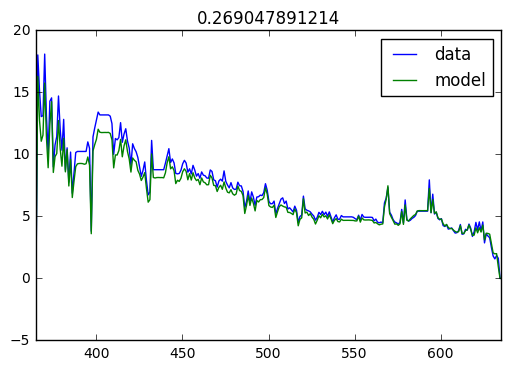

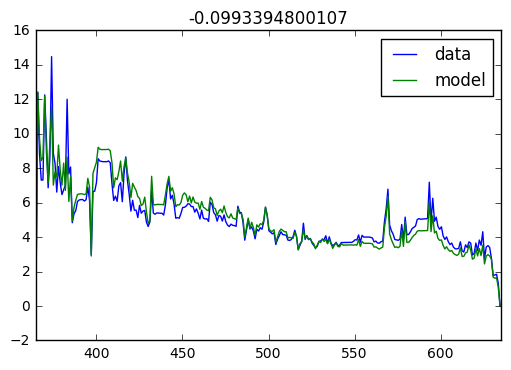

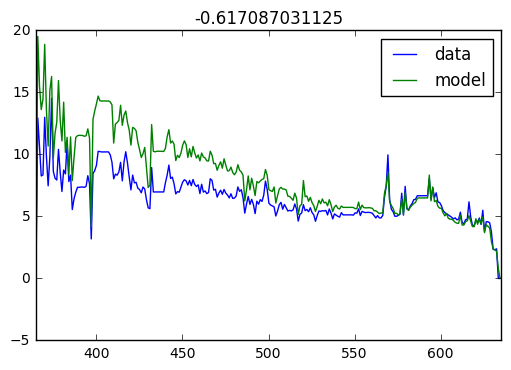

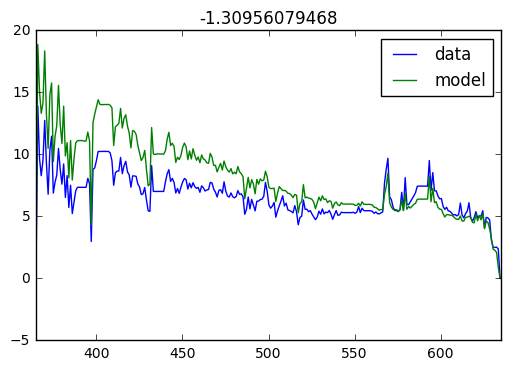

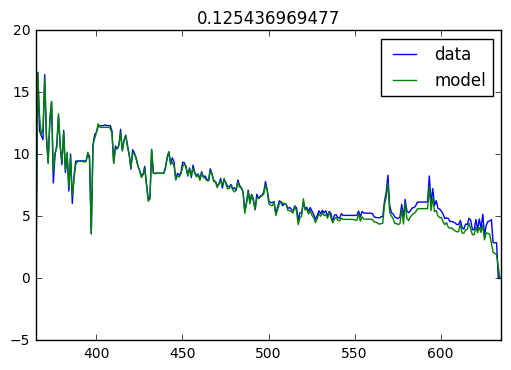

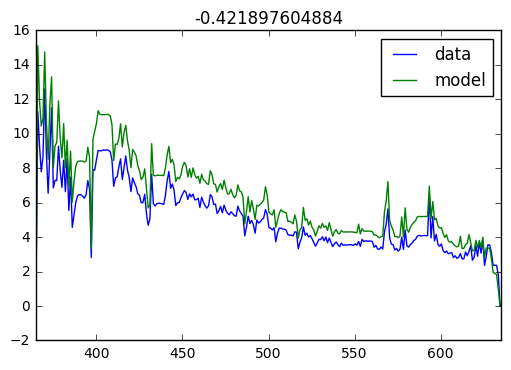

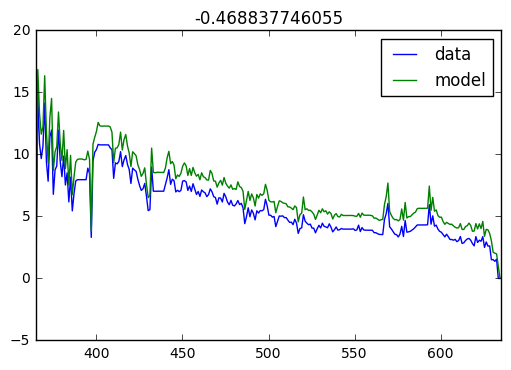

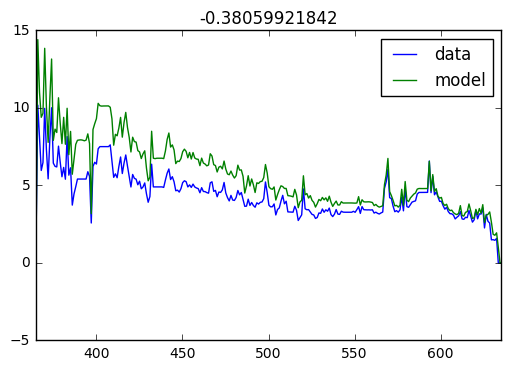

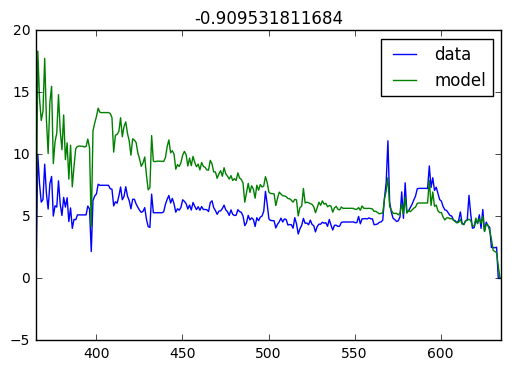

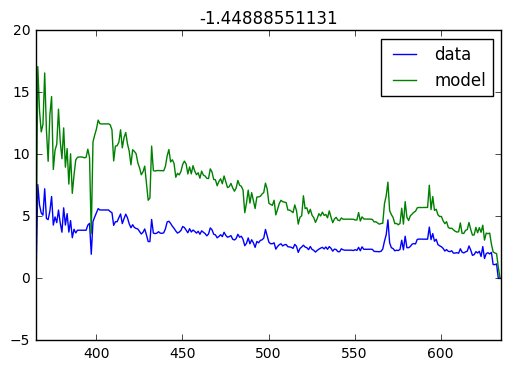

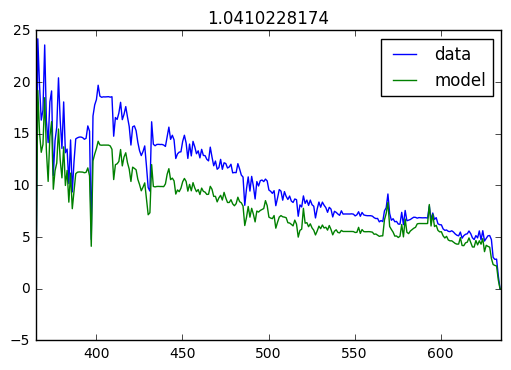

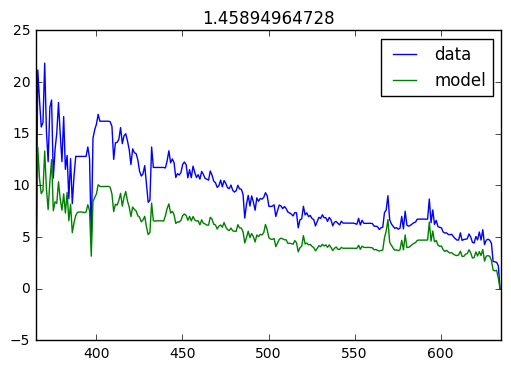

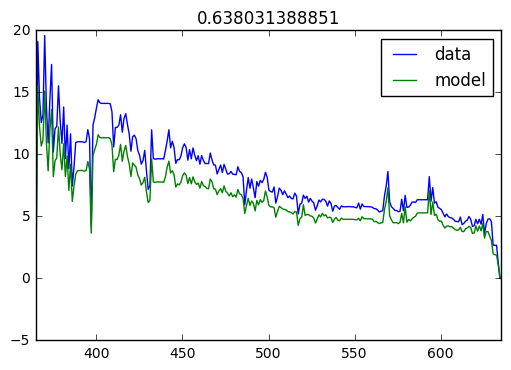

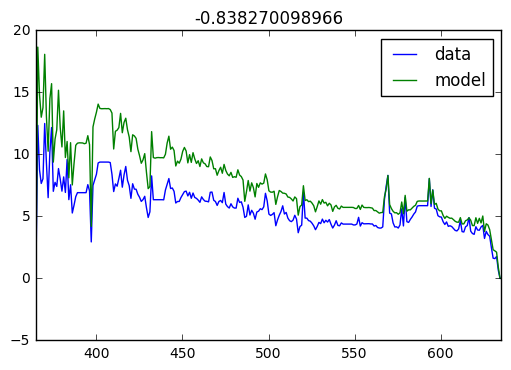

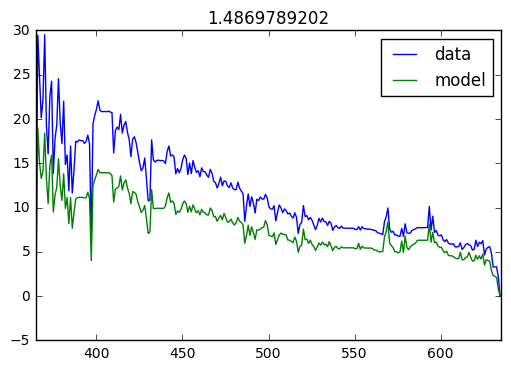

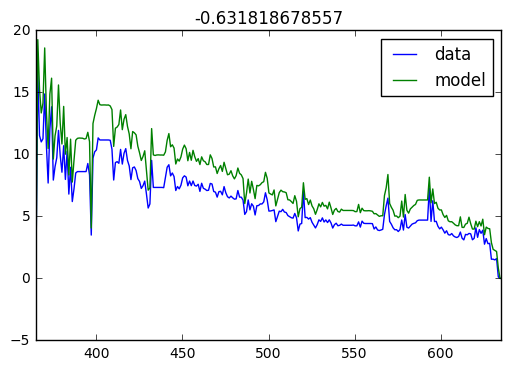

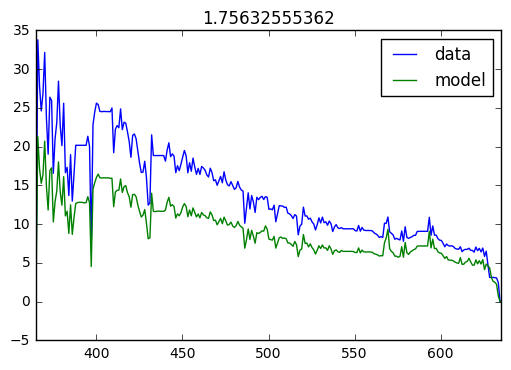

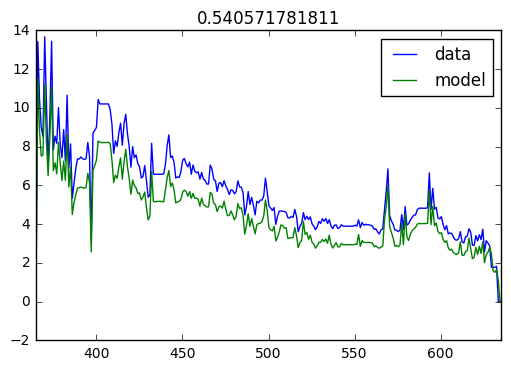

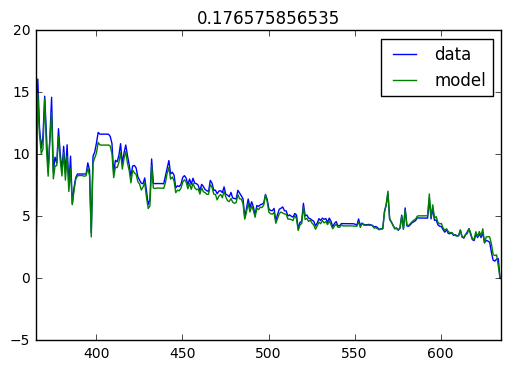

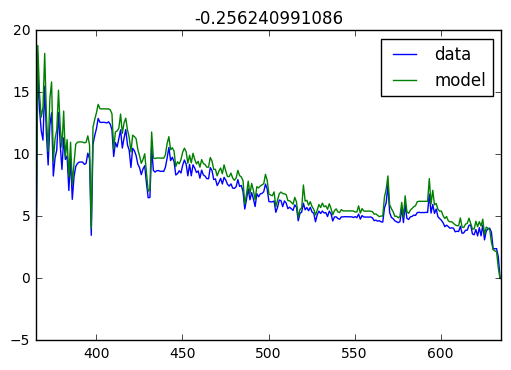

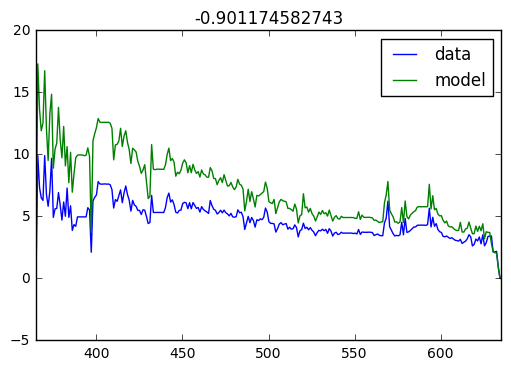

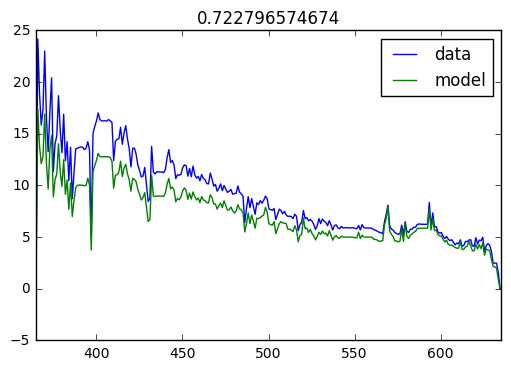

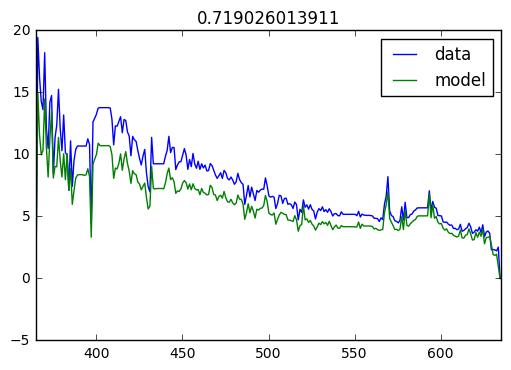

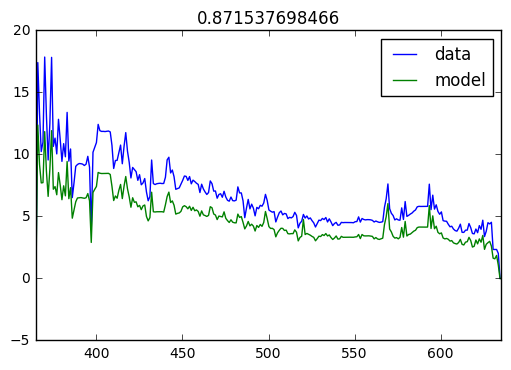

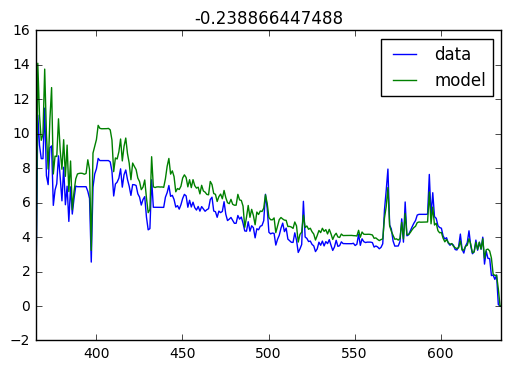

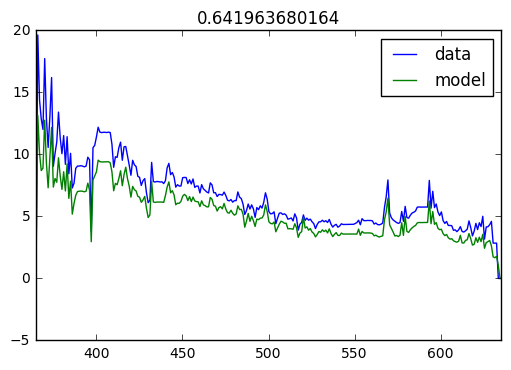

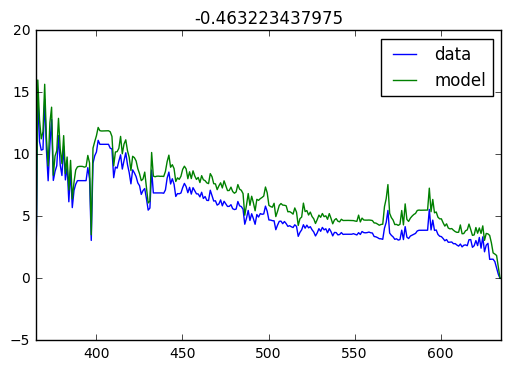

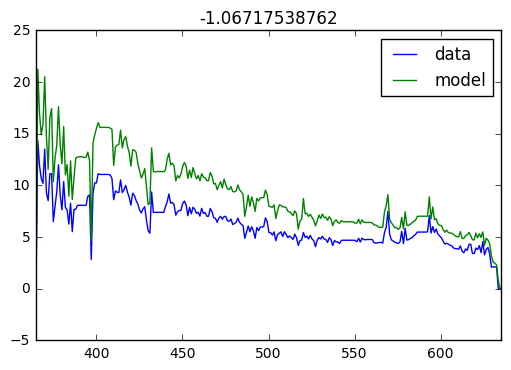

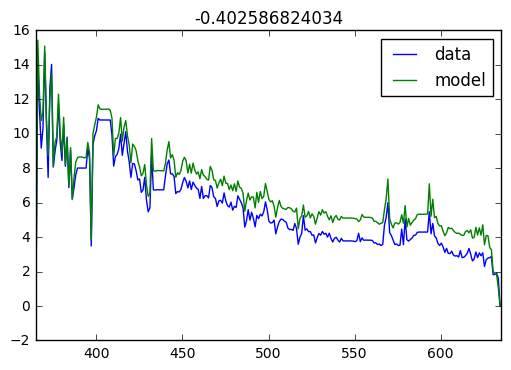

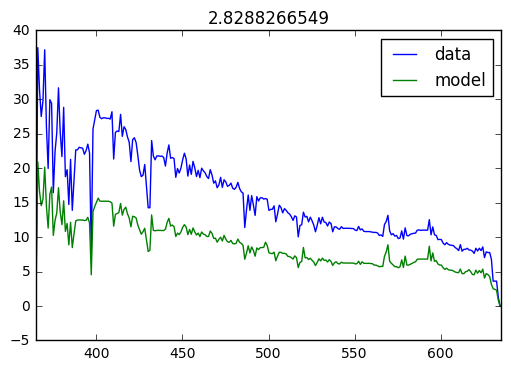

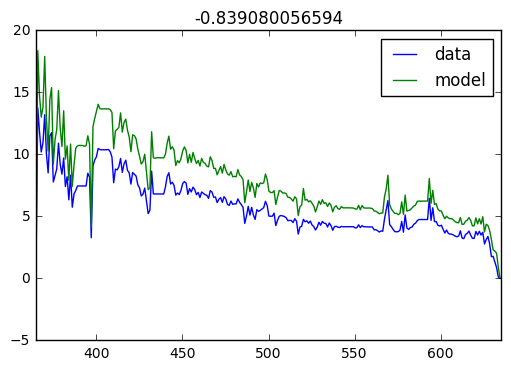

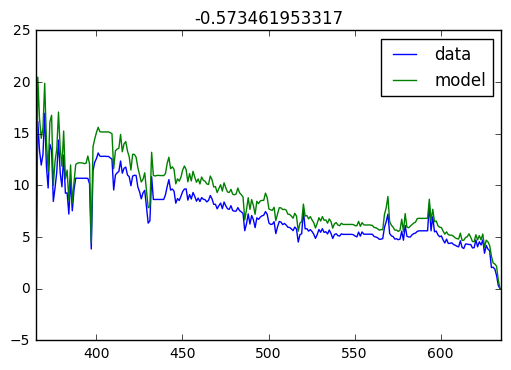

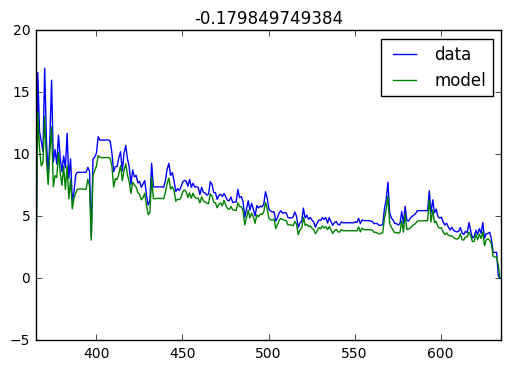

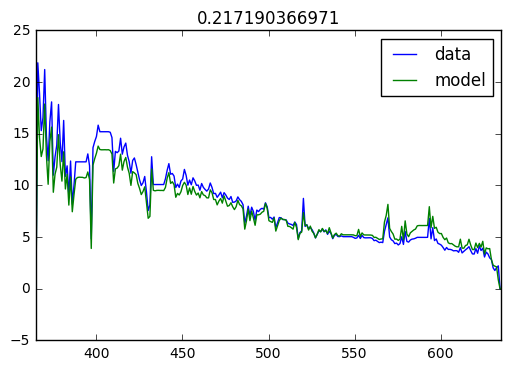

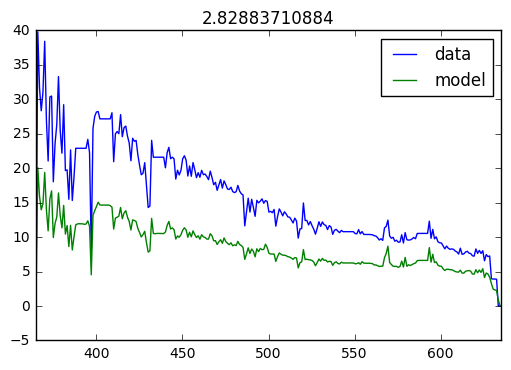

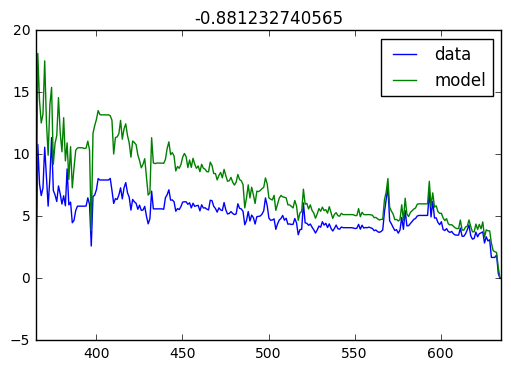

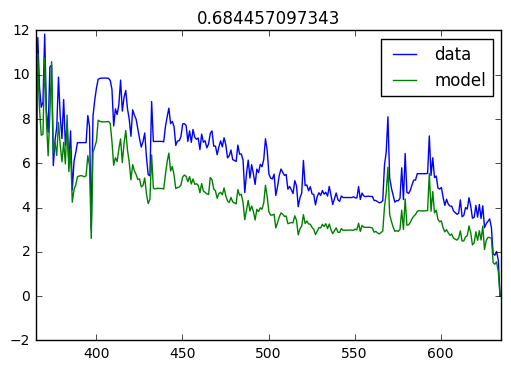

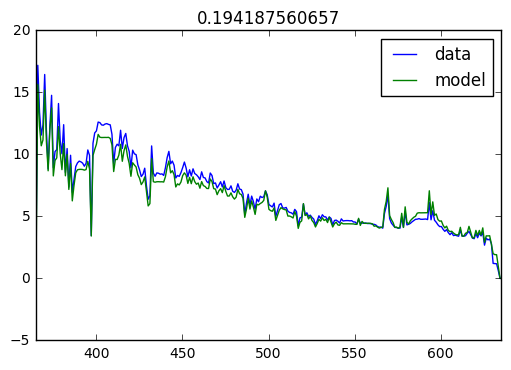

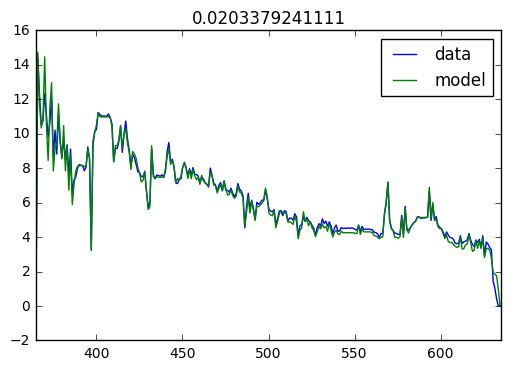

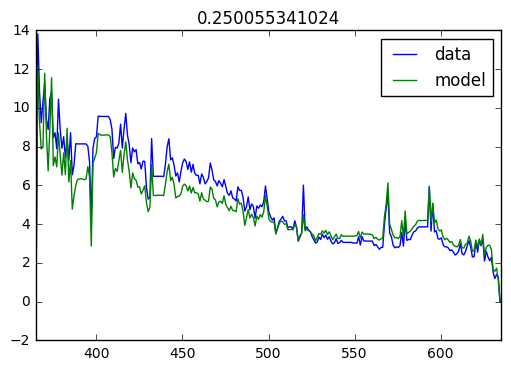

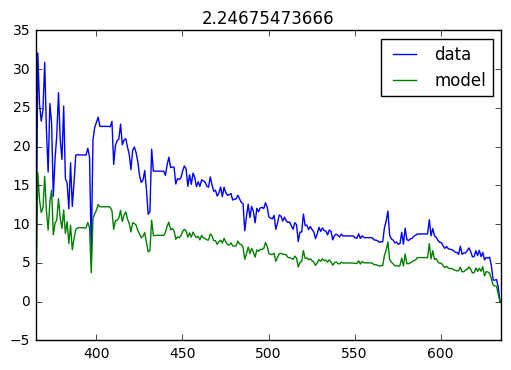

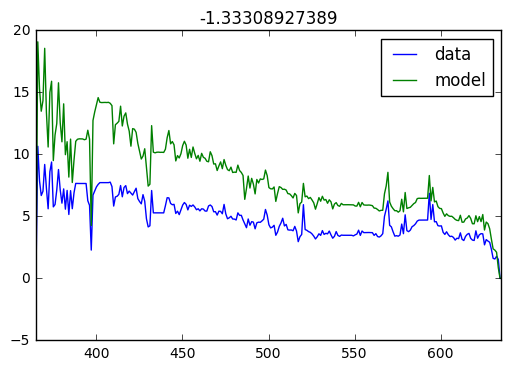

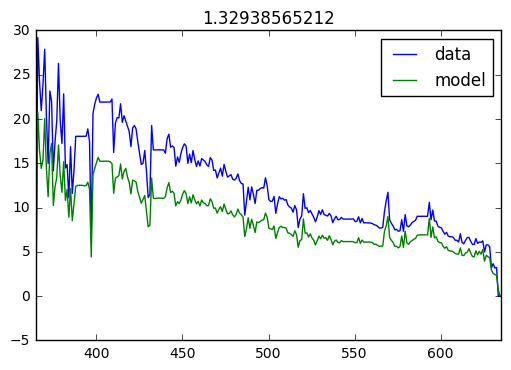

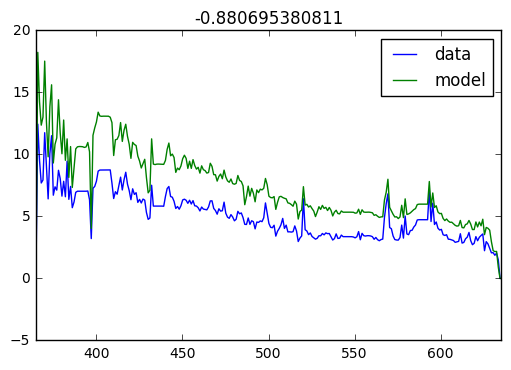

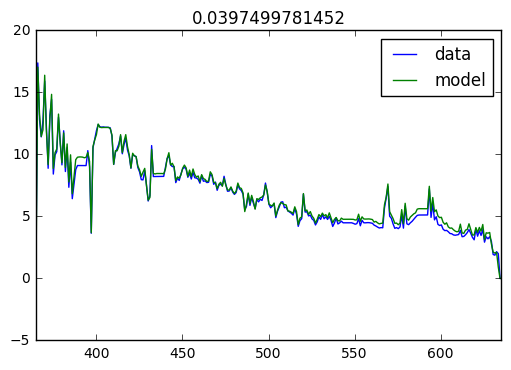

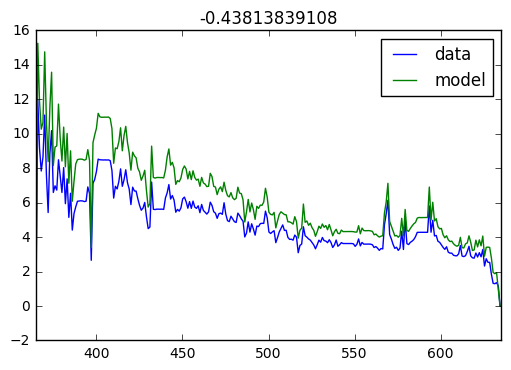

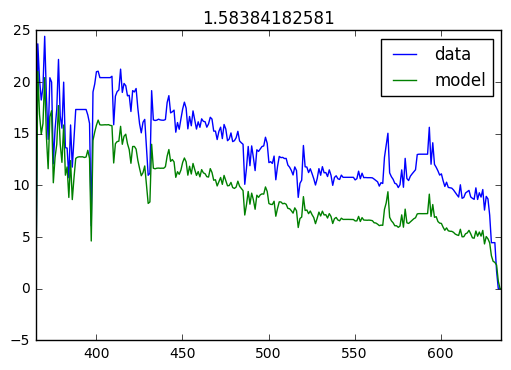

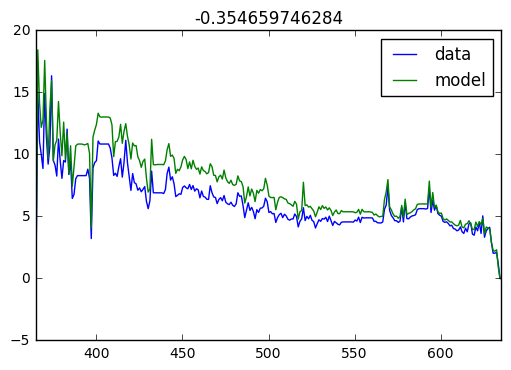

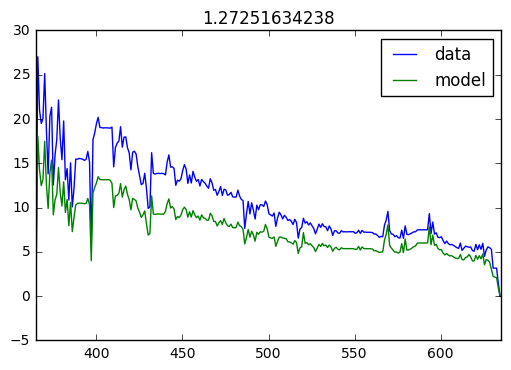

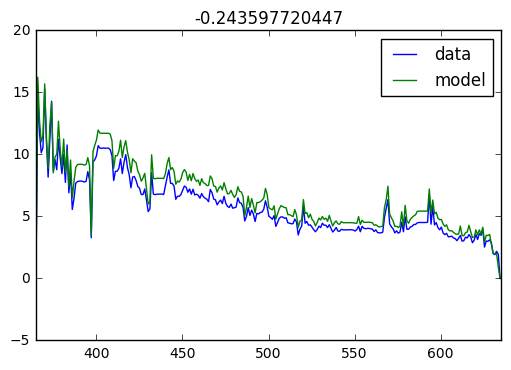

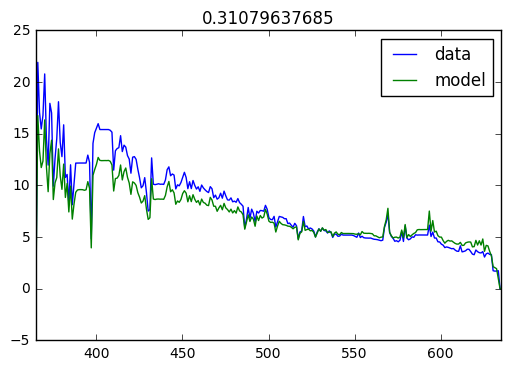

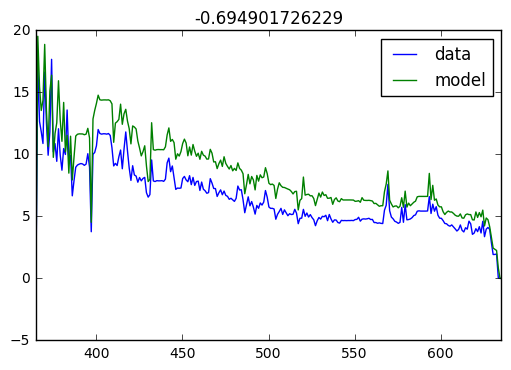

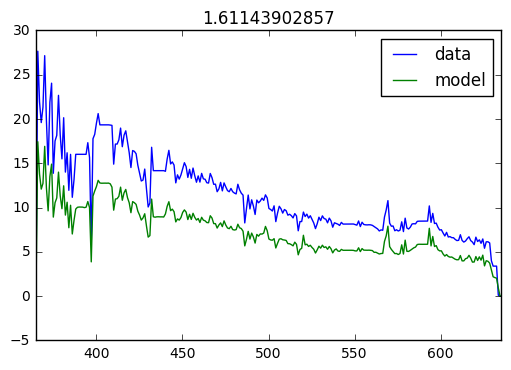

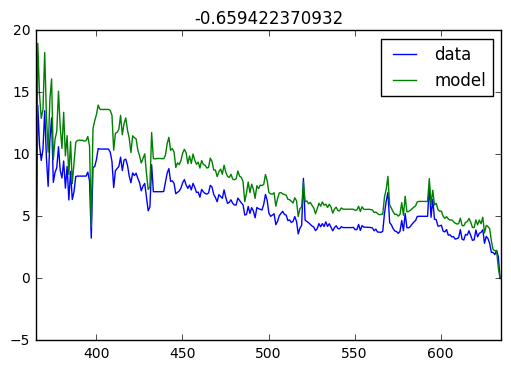

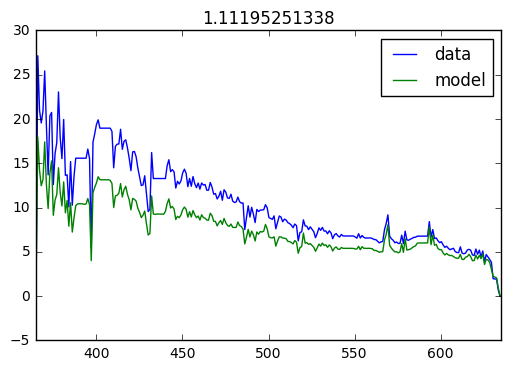

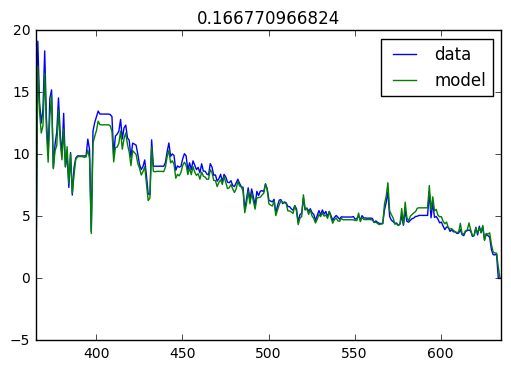

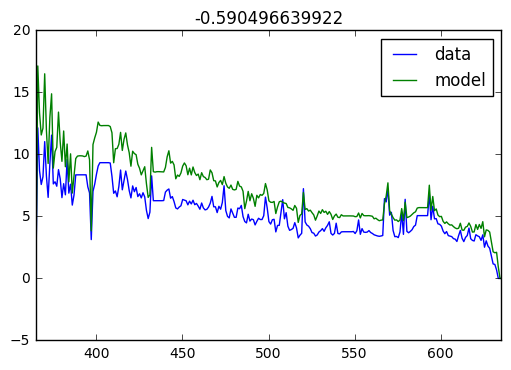

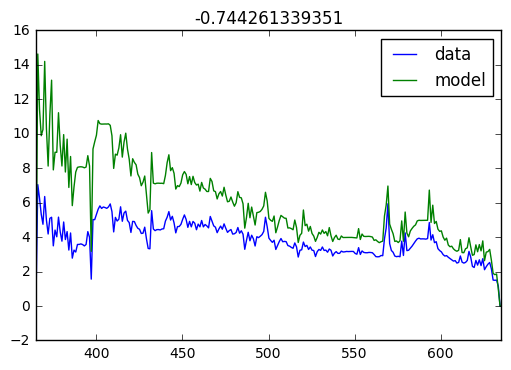

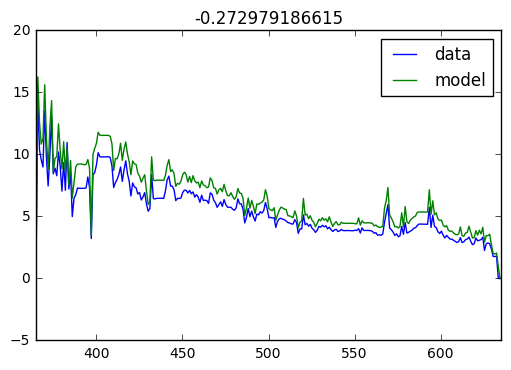

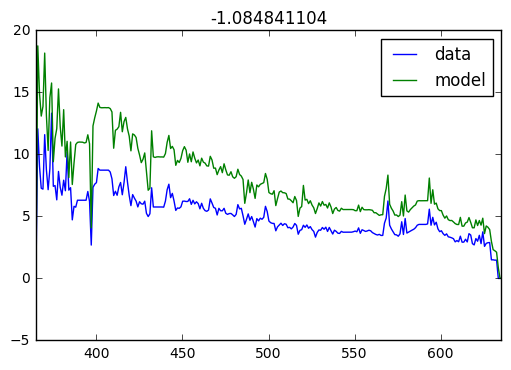

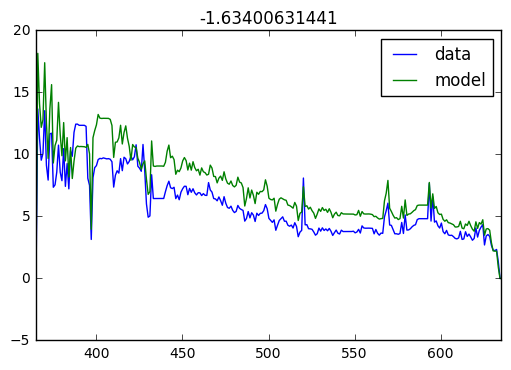

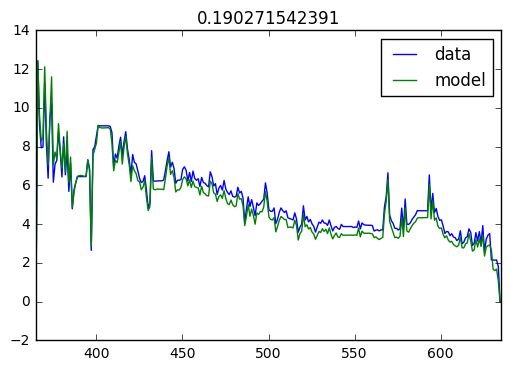

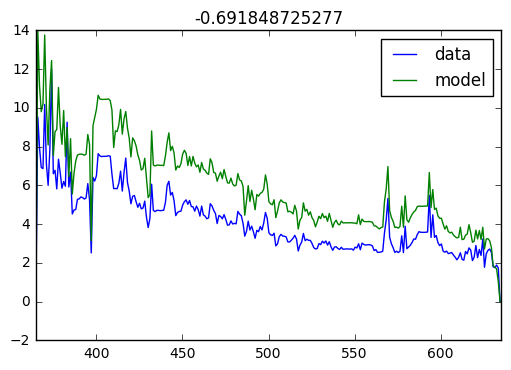

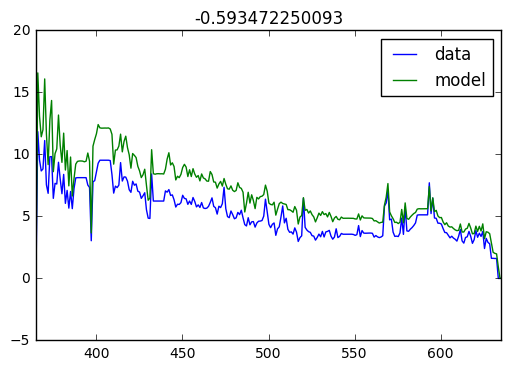

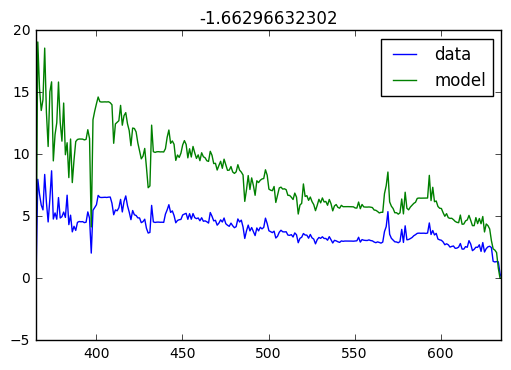

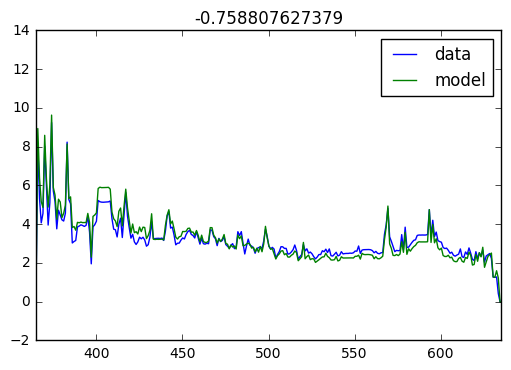

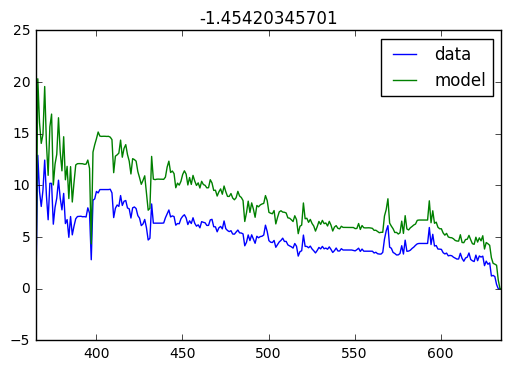

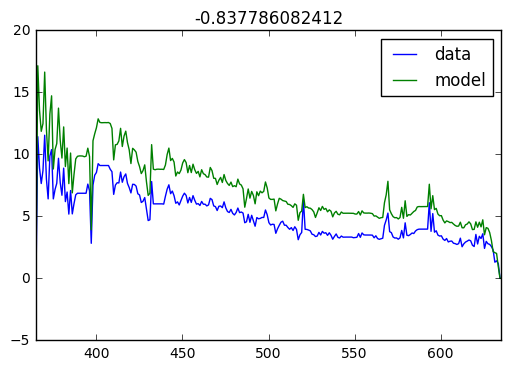

In [1047]:
for i in range(len(Cont_spectra)):
    This_spectrum = Cont_spectra[i]
    This_Data = Data[i]
    Model_Spectrum = []
    for ii, result in enumerate(Results):
        Model_Spectrum.append(test_model(result, This_Data[:,ii]))
    
    plt.figure()
    res = This_spectrum - Model_Spectrum
    #plt.plot(Sky.Model['wave_range'], res)
    plt.plot(Sky.Model['wave_range'], This_spectrum, label = 'data')
    plt.plot(Sky.Model['wave_range'], Model_Spectrum, label = 'model')
    plt.title(np.mean(res))
    plt.legend()
    plt.xlim(365,635)
    